# Next Pitch

## Introduction

Baseball is a game of probabilities. It is also a game of educational guesses. A hitter has about four-tenths of a second between the time the ball leaves the pitchers hand and is past the hitter. A swing is not instantaneous, which means a hitter has even less than four-tenths of a second to decide to swing, but deciding to swing is not enough. The hitter must decide where to swing and if the pitch is a fastball, changeup, curveball etc. which all have different speeds and movement. This is an increadibly difficult feat as evidence by the fact that one can fail 70% of the time and if he continues at that rate he will be considered one of the best hitters in the game. There are very few if any other sports, careers, games, or hobbies where failing 70% of the time is good. So, how could one make this difficult feat easier? 

As mentioned, a hitter must take into account the speed, location, and type of a pitch. The hitter must do this extremely quickly, but what if the hitter knew all this information before the pitch even left the hand of the pitcher? The difficult task of hitting, though still extremely hard, would be somewhat easier. Therefore, my goal is to determine whether it is possible to predict the type, speed, and location of the next pitch? In order to answer this question I first will acquire a data set, clean the dat set and perform some initial analysis to determine which factors could be relevant in predicting the next pitch.

## Data Description

In order to predict the next pitch, I will need to have lots of information on the specific pitcher, batter and previous pitches. Pitchf/x is a system that is installed in every Major League Ballpark. The system collects pitch-by-pitch data containing features such as batter, pitcher, count, inning, pitch type, pitch outcome, etc. The data I will be using comes from three sets that are directly from Pitchf/x.

The first data set is the Pitchf/x data set that contains information on every pitch thrown in a Major League Baseball game from 2013-2015. The other two data sets contain yearly averages for pitchers and batters such as ERA, strikeouts, batting average, HR for the years 2013-2015. This data is very reliable as Pitchf/x is the certified system of the Major League.

### Dataframes

To begin I set up the libraries and tools that I will use later

In [34]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
from pydataset import data
from __future__ import division

#### Pitcher and Batter Dataframes

First, I make the pitcher and batter dataframes. These dataframes contain yearly information on all pitchers and batters, such as number of at bats, total innings pitched, ERA, etc. These will be useful to limit the pitchfx data set to contain only pitches thrown by pitchers who have a large enough sample size to train the future models. 

In [35]:
#makes the pitcher and batter dataframe respectively
pitcher = pd.read_csv('Data/Pitching_Statistics.csv')
batter = pd.read_csv('Data/Batting_Statistics.csv')   

Initally, I drop two columns: the first column, which is an unnamed index, and 'rWAR', which is not neccessary for this project. Next, I calculate the number of duplicates, which is what this block of code outputs. 

In [36]:
#Drop Rwar and the index column
pitcher.drop(['rWAR',pitcher.columns[0]],axis=1, inplace = True)
batter.drop(['rWAR',batter.columns[0]],axis=1, inplace = True)  
#Prints the number of duplicates in batter DF and pitcher DF respectively    
print sum(batter.duplicated())                              
print sum(pitcher.duplicated())                         


608
358


This computation shows there are 608 batter duplicates and 358 pitcher duplicates. Thus, I drop the duplicates.

In [37]:
pitcher.drop_duplicates(inplace  = True) #Drops the 358 pitcher duplicates
batter.drop_duplicates(inplace  = True)  #Drops the 608 pitcher duplicates

I drop all pitchers that faced fewer than 400 batters in the last 3 years and all batters that had fewer than 400 plate appearances. That way, I ensure the batter and pitcher data frames only contain batters and pitchers with a large enough sample size of pitches to be useful for future modeling.

In [38]:
#only pitchers with 400 or more TBF over the past 3 years
pitcher2 = pitcher.groupby('pitcher_id')
pitcher2 = pitcher2.sum()[pitcher2.sum()['TBF'] >= 400]
pitcher = pitcher[pitcher['pitcher_id'].isin(pitcher2.index)]
#only batters with 400 or more AB over the past 3 years
batter2 = batter.groupby('batter_id')
batter2 = batter2.sum()[batter2.sum()['AB'] >= 400]
batter = batter[batter['batter_id'].isin(batter2.index)]

#### Pitchfx Dataframe 

Now, I make the Pitchf/x dataframe. This dataframe has detailed information on every pitch. Below is a sample of the data in this dataframe and the number of entries for each column/feature. 

In [39]:
#Creates the fx df
fx = pd.read_csv('Data/pitchfx.csv')
#Outputs the list of columns and the number of entries for each column
fx.count()

Unnamed: 0        2114497
game_id           2114497
game_date         2114497
year              2114497
sv_pitch_id       2114497
at_bat_number     2114497
pitch_number      2114497
inning            2114497
top_inning_sw     2114497
event_type        2114497
event_result       566940
pre_balls         2114497
pre_strikes       2114497
pre_outs          2114497
batter_id         2114497
bat_side          2114497
pitcher_id        2114497
throws            2114497
initial_speed     2114497
plate_speed       2114497
pitch_type        2114259
break_x           2114497
break_z           2114497
plate_x           2114497
plate_z           2114497
init_pos_x        2114497
init_pos_y        2114497
init_pos_z        2114497
init_vel_x        2114497
init_vel_y        2114497
init_vel_z        2114497
init_accel_x      2114497
init_accel_y      2114497
init_accel_z      2114497
HitTrajectory     2114419
PlaybyPlay        2114497
Runneron1st_ID     598969
Runneron2nd_ID     411493
Runneron3rd_

#### Excess Data

The Pitchfx data set is very expansive and has a lot of information that does not provide value within the scope of this problem. The code below drops some extraneous columns. I am dropping information on the position, velocity, and acceleration of the pitch out of the pitcher’s hand because my goal is to have the prediction be usable for a batter. A batter does not use that information.  He is interested in the information about the pitch as it reaches the plate such as pitch speed, pitch type, and pitch location. The initial break of the ball or the velocity of the ball in all 3 directions does not provide valuable information to a batter. Moreover, the data points that I drop are primarily used to determine the pitch type. Thus, it is sufficient to focus on pitch type and so I drop those values.

In [40]:
fx.drop(['plate_speed',fx.columns[0],'break_x', 'break_z','init_pos_x','init_pos_y',\
         'init_pos_z','init_vel_x','init_vel_y','init_vel_z','init_accel_x','init_accel_y',\
         'init_accel_z'],axis=1, inplace = True)

#### Missing Data

The previous computation showed that my data set is missing very few values. The 'event_result' is the result of an at bat, so it will not have an entry on every pitch because many at bats take multiple pitches before having a result. Also, not every at bat has runners on base, so again I expect the count of those columns to be lower than the rest. The 'pitch_type' count and 'HitTrajectory' columns have fewer entries than the rest, which could be cause for alarm. But, since there are only about 300 entries with missing values for those columns, it will not impact my data set of 2 million rows and thus I drop those rows. 

In [41]:
fx.dropna(subset = ['pitch_type'],inplace = True)
fx.dropna(subset = ['HitTrajectory'],inplace = True)

#### Pitch Type

An important feature in predicting the next pitch is pitch type, which has the following entries:
![title](pitch_type.png)

Note: 'SL' is missing from this list. 'SL' = Slider.

There is one pitch type labeled unidentified/unknown and because pitch type is an important feature in predicting the next pitch, I need to drop all pitches with the label unknown/unidentified. This computation shows how many rows have unknown pitch type 'UN' and unidentified 'XX'.

In [42]:
print sum(fx['pitch_type']=='UN')
print sum(fx['pitch_type']=='XX')

75
0


Now, I remove the 75 rows that have pitch type 'UN' from the fx dataframe.

In [43]:
fx = fx[fx.pitch_type != 'UN']

The last bit of cleaning to my fx dataframe is to limit the dataframe so that it contains only pitches thrown by pitchers to batters that are in the pitcher and batter dataframe, respectively.  

In [44]:
#restrics fx df to only have pitchers from our pitcher df
fx = fx[fx['pitcher_id'].isin(pitcher.pitcher_id)]
#restrics fx df to only have batters from our batter df
fx = fx[fx['batter_id'].isin(batter.batter_id)]    


Now, after all the cleaning I count the remaining pitches in our dataframe:

In [45]:
fx.count()[0]

1540175

### Feature Engineering

#### Pitch Location

My fx dataframe contains the x location and z location (based on the catcher's perspective) of any given pitch . See diagram below:![title](diagram.png)

However, for the purposes of this project I will group pitches into generic locations.  It is not necessary for a hitter to know the the exact amount that a pitch is away from the center of the plate. ( e.g., if a pitch was 3.2 inches or 3.3 inches off the plate). What is necessary is to know if a pitch is low, high, inside, or outside. A batter will not be looking for 3.23 inches off the plate, but rather a pitch outside. So, I break the strike zone down into 9 boxes, labeled 1-9.

The definition of the strike zone is, "the area over home plate the upper limit of which is a horizontal line at the midpoint between the top of the shoulders and the top of the uniform pants, and the lower level is a line at the hollow beneath the kneecap" and is determined by "the batter's stance as the batter is prepared to swing at a pitched ball." So, the strike zone varies depending on the height of the player. However, I will make an average strike zone as this is what Pithf/x and other reputable systems do. Home plate is 17" and the strike zone is a little beyond each side, in case the ball is half over the plate and half off the plate. So, a good estimate of an average strike zone is 18" wide. The average player in the MLB is 6'1" The distance from the knees to mid chest is usually about 1/3 of ones height. So, a good estimate for the height of the zone is 24". Thus, the average strike zone is 18" by 24". Pitchf/x, which is the official zone regulation used by the MLB, follows these estimates exactly and says the strike zone has the dimensions shown in the plot below.

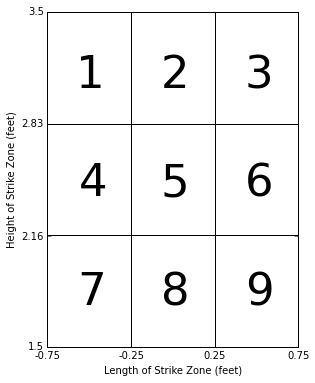

In [46]:
l = 3
plt.figure(num=None, figsize=(1.5*l, 2*l), dpi=80, facecolor='w', edgecolor='k')
#Plot the vertical lines inside the strike zone
plt.plot(np.array([.25]*100), np.linspace(1.5, 3.5, 100), color="black")
plt.plot(np.array([-.25]*100), np.linspace(1.5, 3.5, 100), color="black")
#Plot the horizontal lines inside the strike zone
plt.plot(np.linspace(-.75, .75, 100),np.array([float(26)/12]*100), color="black")
plt.plot(np.linspace(-.75, .75, 100),np.array([float(34)/12]*100), color="black")
plt.axis('tight')
#Make the x and y ticks that we want to appear on the graph
yticks = [1.50,2.16,2.83,3.50] 
xticks = [-.75,-.25,.25,.75]
plt.yticks(yticks, yticks)
plt.xticks(xticks,xticks)
plt.ylabel('Height of Strike Zone (feet)')
plt.xlabel('Length of Strike Zone (feet)')
#This next block labels each quadrant 1-9
plt.text(-.55, 3.05, '1', fontsize = 45)
plt.text(-.05, 3.05, '2', fontsize = 45)
plt.text(.45, 3.05, '3', fontsize = 45)
plt.text(-.55, 2.4, '4', fontsize = 45)
plt.text(-.05, 2.4, '5', fontsize = 45)
plt.text(.45, 2.4, '6', fontsize = 45)
plt.text(-.55, 1.75, '7', fontsize = 45)
plt.text(-.05, 1.75, '8', fontsize = 45)
plt.text(.45, 1.75, '9', fontsize = 45)
plt.show()

While breaking down the strike zone is helpful, not every pitch is a strike. So, it is necessery to break down the pitches outside the strike zone into bins as well. Below is the diagram for the break down of pitches outside the strike zone.

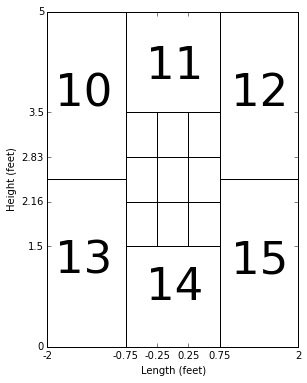

In [47]:
def plotting_balls():
    l = 3
    plt.figure(num=None, figsize=(1.5*l, 2*l), dpi=80, facecolor='w', edgecolor='k')
    #Plots the vertical lines inside the strike zone
    plt.plot(np.array([.25]*100), np.linspace(1.5, 3.5, 100), color="black")
    plt.plot(np.array([-.25]*100), np.linspace(1.5, 3.5, 100), color="black")
    #Plots the horizontal lines inside the strike zone
    plt.plot(np.linspace(-.75, .75, 100),np.array([float(26)/12]*100), color="black")
    plt.plot(np.linspace(-.75, .75, 100),np.array([float(34)/12]*100), color="black")
    plt.plot(np.linspace(-.75, .75, 100),np.array([3.5]*100), color="black")
    plt.plot(np.linspace(-.75, .75, 100),np.array([1.5]*100), color="black")
    #Plots the horizontal lines outside the strike zone
    plt.plot(np.linspace(-2, -.75, 100),np.array([2.5]*100), color="black")
    plt.plot(np.linspace(.75, 2, 100),np.array([2.5]*100), color="black")
    #Plots the long vertical lines
    plt.plot(np.array([2]*100), np.linspace(0, 5, 100), color="black")
    plt.plot(np.array([-2]*100), np.linspace(0, 5, 100), color="black")
    plt.plot(np.array([.75]*100), np.linspace(0, 5, 100), color="black")
    plt.plot(np.array([-.75]*100), np.linspace(0, 5, 100), color="black")
    plt.axis('tight')
    #Make and plot our x and y ticks that we want to appear
    yticks = [0,1.50,2.16,2.83,3.50,5]
    xticks = [-2,-.75,-.25,.25,.75,2]
    plt.yticks(yticks, yticks)
    plt.xticks(xticks,xticks)
    #Label the x and y axis
    plt.ylabel('Height (feet)')
    plt.xlabel('Length (feet)')

#Calls the plotting function
plotting_balls()    
#This chunk labels the blocks outside the strike zone 10-15    
plt.text(-1.8, 3.6, '10', fontsize = 45)
plt.text(-.35, 4, '11', fontsize = 45)
plt.text(1, 3.6, '12', fontsize = 45)
plt.text(-1.8, 1.1, '13', fontsize = 45)
plt.text(-.35, .7, '14', fontsize = 45)
plt.text(1, 1.1, '15', fontsize = 45)


plt.show()

Now, I use the x and y location from the fx dataframe to create a new feature that will label every pitch 1-15. Thus, when I begin modeling, rather than using the exact location of the pitch, I will use the fact that a pitch was in quadrant 9 ("low and away") or quadrant 5 ("right down the pipe") to determine what the next pitch will be. 

To accomplish this I make a new function pitch_location. This function accepts the x and z location of every pitch in my dataframe. First I determine, through a series of if statements, if the pitch location is a ball and which ball quadrant the coordinates lie in. If the pitch is in the strike zone we determine which part of the 3X3 grid the coordinates lie. 

In [48]:
def pitch_location(x, z):   
    """This function determines which bucket a pitch location falls in.
       Arguments: x and z cordinates of a pitch.
       Returns new, which is the bucket (1-15) that the pitch falls in"""
    if x >= .75:      #If the ball is outside the strike zone to the right of the catcher
        if z>= 2.5:   #If the ball is above the upper half of the strike zone
            new = 12
        else:         #If not in the upper half, must be in the lower half
            new = 15
    elif x <= -.75:   #If the ball is outside the strike zone to the left of the catcher
        if z >= 2.5:  #If the ball is above the upper half of the strike zone 
            new = 10
        else:         #If not in the upper half, must be in the lower half
            new = 13
    else:             #The ball must be inside the length of the strike zone
        if z >= 3.5:  #If the ball is above the strike zone
            new = 11
        elif z <= 1.5:#If the ball is below the strike zone
            new = 14
        else:         #The ball must be in the strike zone
            """We make an x_offset and y_offset to bring the bottom left corner of the
            strike zone to be the origin"""
            x_offset = .75 
            y_offset = -1.5
            grid = np.array([[1,2,3],[4,5,6],[7,8,9]]) #We make a grid that matches the strike zone buckets
            
            """We set our new value to be the value of the grid at the corresponding index
            The first index corresponds to the rows, which is the z value in the strike zone.
            So, I off set the z value to bring it down to the origin then integer divide it by the 
            height of the buckets to find if the value is in the first row, second row, or third row
            and since 1 is at the top we must do 2-. The second index is the same methodology. 
            we off set the x value and then integer divide by the length to find which column the x value is in"""
            new = grid[2-(z+y_offset)//(2./3),(x+x_offset)//.5]
    return new

#Now I run through the pitch location function on every x,z in the dataframe and make a new column (pitch_location)
fx['pitch_location'] = [pitch_location(x,z) for x,z in fx[['plate_x','plate_z']].values] 

/Applications/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


#### Pitch Speed

The fx dataframe contains every pitche's speed to the tenth decimal place. However, for this project it is better to group pitch speed into buckets as I did with pitch location. The reason is that it is very unlikely that any sequence of pitches is the exact same speed as a previous sequence of pitches. For example: Pitcher A might throw three pitches 87.1, 92.3, and 91.7. Then a month later he throws three pitches again 87.8, 92.5, 91.3. The later three pitches are, for all practical purposes, the same speed as the prior set of three. However, in our current dataframe they are different. So, I group pitches into buckets that will label pitches such 87.1 and 87.8 as the same speed. The buckets will be as follows:


| < 66.6|66.7-70|70.1-73.3|73.4-76.6|76.7-80|80.1-83.3|83.4-86.6|86.7-90|...|96.7-100| > 100|
|:-----:|:-----:|:-------:|:-------:|:-----:|:-------:|:-------:|:-----:|:-:|:------:|:----:|
|   65  | 68    |    72   |    75   |   78  |    82   |    85   |   88  |...|    98  |  102 |


This is also useful and practical as a batter is not looking for exaclty 79.3 mph, but rather he is thinking high 70's. It is common to have three bins for every 10 MPH: 1 bin for low, 1 for middle, and 1 for high. This will also help our future model return a solution that is more practical. 

Below is a function that takes in the speed already contained in my dataframe and then creates the new value to be inputted into a new column called 'speed' based on the bins above. My function scales the velocity input down to where 66.6 = 0 and then I use integer division to divide the scaled down velocity by the length of each bin to find which bin the pitch is in. Then I scale that result back up to the desired return values. 

In [49]:
def my_filter(x):
    if x>= 10: #This means that the initial velocity is greater than 100 because 100-66.6//10/3 =10
        return 102
    elif x<0:  #This means our initial velocity is <66.666
        return 65 
    return round(64.6666666 + (x+1)*10/3. + .2)               #This formula scales our value back up to the desired MPH
my_filter = np.vectorize(my_filter)
fx['speed'] = my_filter((fx['initial_speed'].values-66.6666)//(10/3.)) #Here we run through our function for each pitch


## Data Visualization

First, I will look at the frequency of pitch types, pitch speeds, and pitch locations. 

#### Pitch Types

The following display is a bar graph showing the frequency of each pitch type.

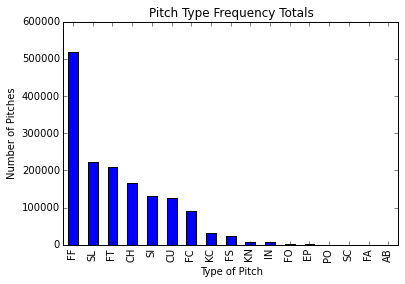

In [50]:
#We plot the values of each pitch type in a bar plot
fx.pitch_type.value_counts().plot(kind='bar', title = 'Pitch Type Frequency Totals')
plt.xlabel('Type of Pitch')
plt.ylabel('Number of Pitches')
plt.show()


This plot shows 'FF' (four seam fastball) is by far the most prevalent pitch. Now, I will graph the percentage of pitch types.

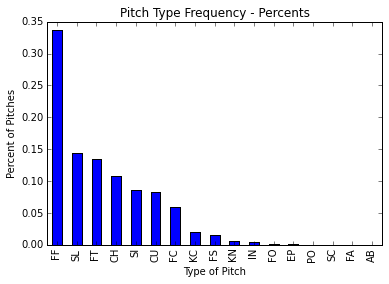

In [51]:
#We create the percentage of each pitch type by dividing the counts by the len of the df then we do a bar plot
percent= fx.pitch_type.value_counts()/len(fx)
percent.plot(kind='bar', title = 'Pitch Type Frequency - Percents')
plt.xlabel('Type of Pitch')
plt.ylabel('Percent of Pitches')
plt.show()

This graph provides some useful introductary information, such as: four-seam fastballs are used about 33% of the time and that over 60% of pitches are either a four-seam fastball, slider, or two-seam fastball. 

#### Pitch Speed

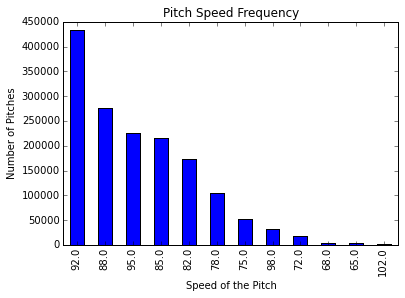

In [52]:
#We plot the values of each pitch speed in a bar plot
fx.speed.value_counts().plot(kind='bar', title = 'Pitch Speed Frequency')
plt.xlabel('Speed of the Pitch')
plt.ylabel('Number of Pitches')
plt.show()

This frequency graph makes sense based on the results from the pitch type frequencies. A majority of pitches are fastballs and sliders, which are usually thrown at a speed of 85-95. This graph shows that the buckets ranging from 85-95 have the highest frequency. So, this graph does not provide too much new information, but it supports the previous results. 

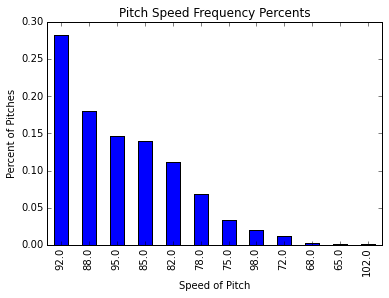

In [53]:
#We create the percentage of each pitch speed by dividing the counts by the len of the df then we do a bar plot
percent = fx.speed.value_counts()/len(fx)
percent.plot(kind='bar', title = 'Pitch Speed Frequency Percents')
plt.xlabel('Speed of Pitch')
plt.ylabel('Percent of Pitches')
plt.show()

Again, we look at the percent of pitches thrown at each speed. The biggest take away is that about 72% of all pitches are between 85 and 95 MPH. However, that is a very large range when thinking about having only four tenths of reaction time to hit a pitch. 

#### Pitch Location

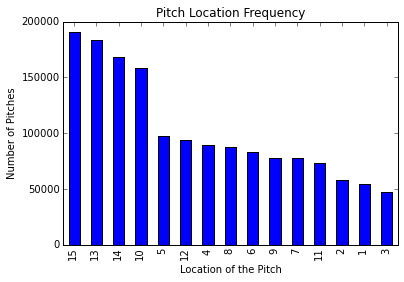

In [54]:
#We plot the values of each pitch location in a bar plot
fx.pitch_location.value_counts().plot(kind='bar', title = 'Pitch Location Frequency')
plt.xlabel('Location of the Pitch')
plt.ylabel('Number of Pitches')
plt.show()

While the two previous graphs provided information on the most common pitch types and speeds, this graph shows that pitch location is all over the place. Naturally, the buckets that contain balls have the highest frequency, because their area is much greater than the area of the strike zone bins. The bottom line is that there appears to be no initial indicator as to the location of a pitch. 

A couple of factors that might impact the pitch location are the handedness of the batter and the pitcher. An inside pitch to a right handed batter is an outside pitch to a left handed batter and generally pitchers tend to throw outside. Thus, I will produce the same pitch location frequency plots, but for combinations of handedness.

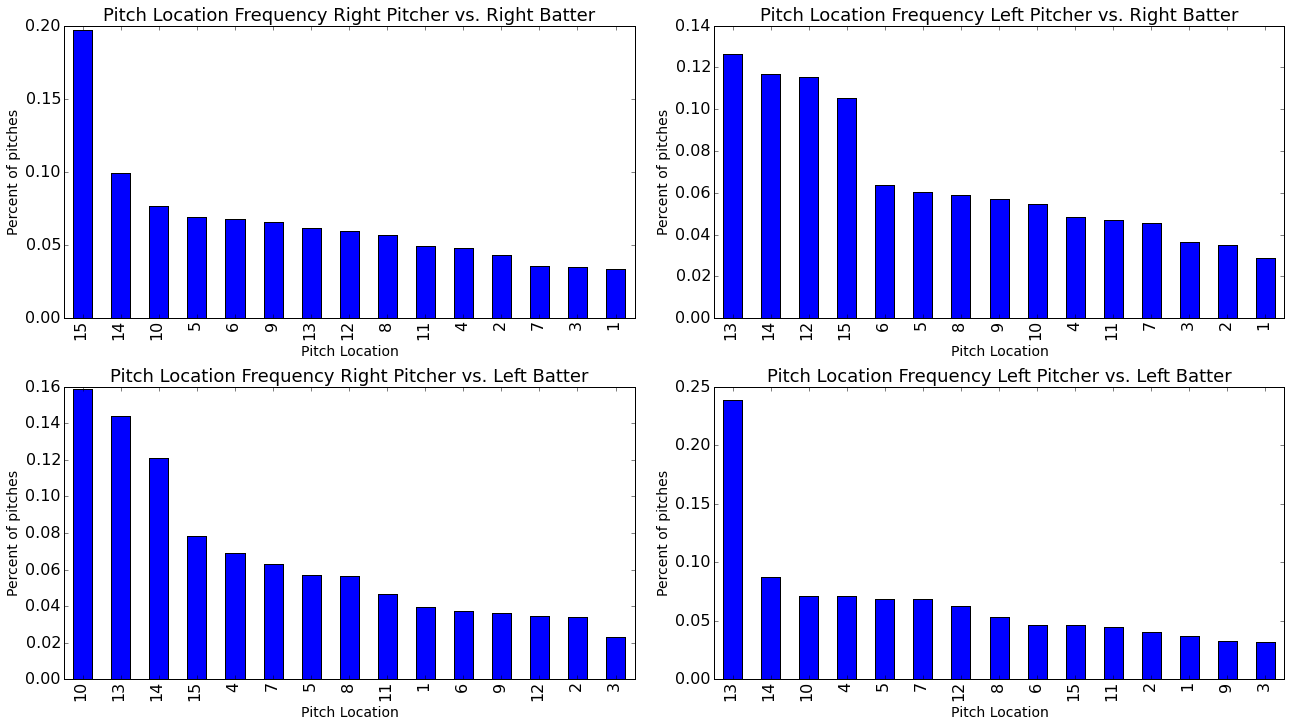

In [55]:
#We set the figure size
plt.figure(figsize=(18,10))
"""We have four subplots, 1 for each combination of pitcher and batter handedness.
In each subplot I make a new dataframe for the specific case, such as RH pitcher and RH batter.
Then I calculate the percent of each pitch location for that specific dataframe
Lastly, I plot the percents in a bar graph. """
plt.subplot(221)
plt.title('Pitch Location Frequency Right Pitcher vs. Right Batter', fontsize = 18)
plt.xlabel('Pitch Location', fontsize = 14)
plt.ylabel('Percent of pitches', fontsize = 14)
RR = fx[(fx['bat_side']=='R') & (fx['throws']=='R')]
percentRR = RR.pitch_location.value_counts()/len(RR)
percentRR.plot(kind='bar', fontsize=16)

plt.subplot(222)
plt.title('Pitch Location Frequency Left Pitcher vs. Right Batter', fontsize = 18)
plt.xlabel('Pitch Location', fontsize = 14)
plt.ylabel('Percent of pitches', fontsize = 14)
RL = fx[(fx['bat_side']=='R') & (fx['throws']=='L')]
percentRL = RL.pitch_location.value_counts()/len(RL)
percentRL.plot(kind='bar', fontsize=16)

plt.subplot(223)
plt.title('Pitch Location Frequency Right Pitcher vs. Left Batter', fontsize = 18)
plt.xlabel('Pitch Location', fontsize = 14)
plt.ylabel('Percent of pitches', fontsize = 14)
LR = fx[(fx['bat_side']=='L') & (fx['throws']=='R')]
percentLR = LR.pitch_location.value_counts()/len(LR)
percentLR.plot(kind='bar', fontsize=16)

plt.subplot(224)
plt.title('Pitch Location Frequency Left Pitcher vs. Left Batter', fontsize = 18)
plt.xlabel('Pitch Location', fontsize = 14)
plt.ylabel('Percent of pitches', fontsize = 14)
LL = fx[(fx['bat_side']=='L') & (fx['throws']=='L')]
percentLL = LL.pitch_location.value_counts()/len(LL)
percentLL.plot(kind='bar', fontsize=16)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

The breakdown of handedness provides much more information on pitch location. Especially when the batter uses the same hand as the pitcher. Notice that for left handed pitchers vs. left handed batters, almost one out of four pitches is in location 13, which is low and away from the left handed batter. For right handed pitchers vs. right handed batters, almost one out of five pitches are in location 15, which is low and away from the right handed batter. The conclusion I draw from these graphs is that the handedness of the batter and pitcher is an important factor in determining the location of a pitch and will be an important feature in our model for predicting future pitches. 

#### Counts and Pitchers

As we saw with handedness of a batter the more that is known about the situation the higher the probability of specific outcomes such as pitch location being outside. Some other important features to explore are pitch counts and the specific pitcher. Below is an example of my idea that as the amount of information increases, the ability to predict the location of the next pitch becomes more likely.

#### Plot 1 - 0-2 Count

This first graph is a plot of every single pitch thrown with the count 0 balls and 2 strikes:

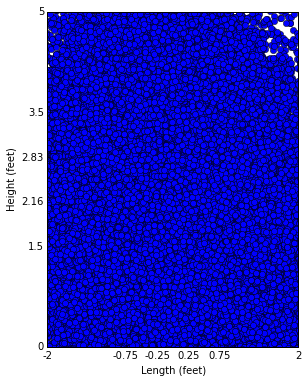

In [56]:
#I call the above function that makes the zone in which pitches are located
plotting_balls()
#I plot the x and z location from our data frame on the condition that it's an 0-2 count
plt.plot(fx[(fx['pre_strikes']==2) & (fx['pre_balls']==0)]['plate_x'],\
         fx[(fx['pre_strikes']==2) & (fx['pre_balls']==0)]['plate_z'], 'ob')
plt.show()

It is evident that the count (0-2) alone does not provide any information pertaining to the location of pitches.

#### Plot 2 - A.J. Burnett

The count by itself does not provide information pertaining to the location of pitches, but what about a specific pitcher? This next graph plots every pitch thrown by one specific pitcher, A.J. Burnett

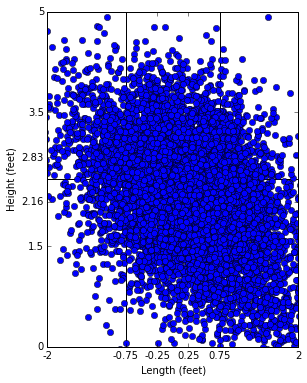

In [57]:
#function from above that plots the zone pitches can fall in
plotting_balls()
#Makes a new dataframe that is the same as the fx dataframe, but only for pitches thrown by A.J. Burnett
specific_pitcher = fx[(fx['pitcher_id']==150359)]
#plot the conditions of 0 balls 2 strikes for our specific pitcher 
plt.plot(specific_pitcher['plate_x'],specific_pitcher['plate_z'], 'ob')

plt.show()

This plot provides a little more information than the count plot, but still not very helpful. This does show that there are a few location bins that A.J. Burnett avoids, but the locations that he does pitch too is still far to varied to provide any value. 

#### Plot 3 - 0-2 Count and A.J. Burnett

Now, I look at the interaction between count and pitcher. So, below is a plot of every pitch A.J. Burnett threw with an 0-2 count:

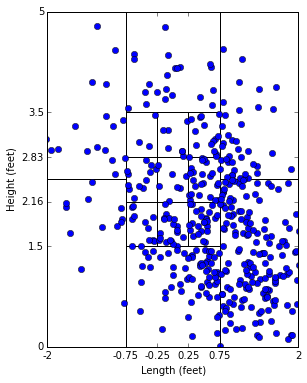

In [58]:
#function from above that plots the zone pitches can fall in
plotting_balls()
plt.plot(specific_pitcher[(specific_pitcher['pre_strikes']==2) & (specific_pitcher['pre_balls']==0)]['plate_x'],\
         specific_pitcher[(specific_pitcher['pre_strikes']==2) & (specific_pitcher['pre_balls']==0)]['plate_z'], 'ob')

plt.show()

This shows that combining these two pieces of information (count and pitcher) the location of the next pitch is much more concentrated.  

#### Plot 4 - 0-2 Count, A.J. Burnett, RH Batter

Now I add one more piece of information, the batter is right handed. The following plot is of every pitch A.J. burnett threw with an 0-2 count to a right handed hitter.

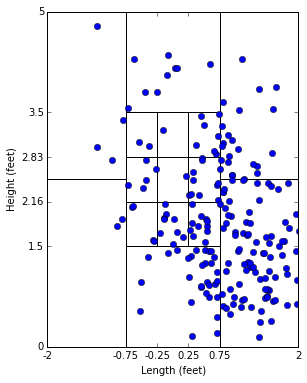

In [59]:
#function from above that plots the zone pitches can fall in
plotting_balls()
#I use the same conditions as above only I add the condition that the batter is right handed
plt.plot(specific_pitcher[(specific_pitcher['pre_strikes']==2) & (specific_pitcher['pre_balls']==0)\
                         &(specific_pitcher['bat_side']=='R')]['plate_x'],\
         specific_pitcher[(specific_pitcher['pre_strikes']==2) & (specific_pitcher['pre_balls']==0)\
                         &(specific_pitcher['bat_side']=='R')]['plate_z'], 'ob')
plt.show()

The pitches seem to be even more concentrated in the lower right quadrant of the zone. These conclusions have all been "eyeball" conclusions, so below is a plot of the percent of pitches that fall into a location bin for the three situations above. 

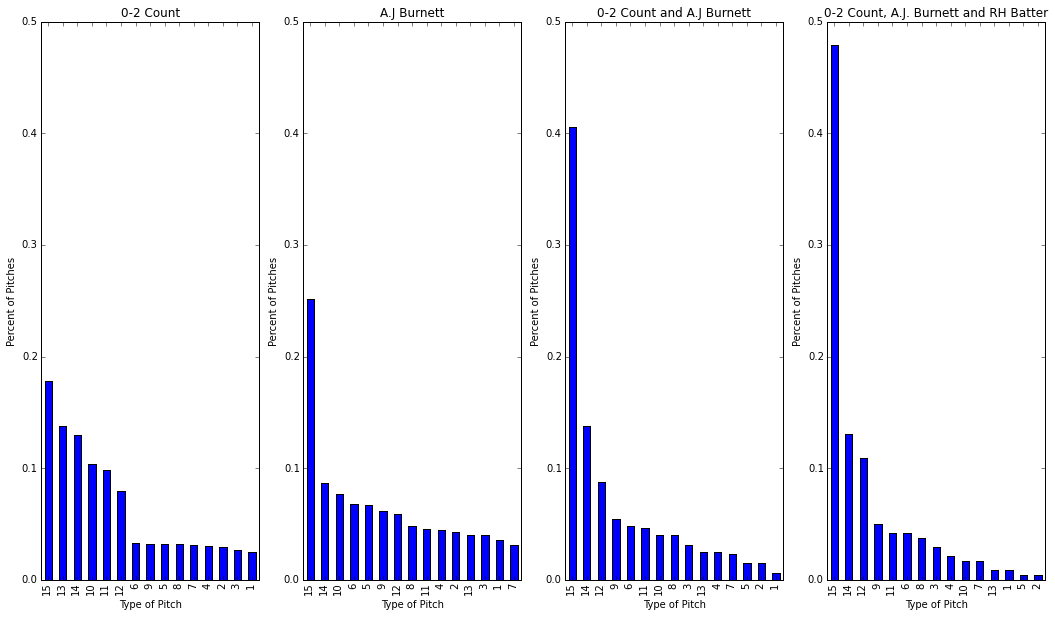

In [60]:
#Set the figure size
plt.figure(figsize=(18,10))
#I have three subplots for each situation
"""In each of the subplot I make a new df that is a subset of the fx df only with the specific conditions 
of the situation, such as 0-2 count for the first subplot. Then I create the percent of each location.
Lastly I plot the percent provide labels, titles and set the y scale to be the same for all 3 plots"""
plt.subplot(141)
raw = fx[(fx['pre_strikes']==2) & (fx['pre_balls']==0)]
percent= raw.pitch_location.value_counts()/len(raw)
percent.plot(kind='bar', title = '0-2 Count')
plt.xlabel('Type of Pitch')
plt.ylabel('Percent of Pitches')
plt.ylim([0,.5])

plt.subplot(142)
percent2 = specific_pitcher.pitch_location.value_counts()/len(specific_pitcher)
percent2.plot(kind='bar', title = 'A.J Burnett')
plt.xlabel('Type of Pitch')
plt.ylabel('Percent of Pitches')
plt.ylim([0,.5])

plt.subplot(143)
new_pitcher = specific_pitcher[(specific_pitcher['pre_strikes']==2) & (specific_pitcher['pre_balls']==0)]
percent2 = new_pitcher.pitch_location.value_counts()/len(new_pitcher)
percent2.plot(kind='bar', title = '0-2 Count and A.J Burnett')
plt.xlabel('Type of Pitch')
plt.ylabel('Percent of Pitches')
plt.ylim([0,.5])

plt.subplot(144)
new_batter = specific_pitcher[(specific_pitcher['pre_strikes']==2) & (specific_pitcher['pre_balls']==0)\
                         &(specific_pitcher['bat_side']=='R')]
percent3 = new_batter.pitch_location.value_counts()/len(new_batter)
percent3.plot(kind='bar', title = '0-2 Count, A.J. Burnett and RH Batter')
plt.xlabel('Type of Pitch')
plt.ylabel('Percent of Pitches')
plt.ylim([0,.5])
plt.show()

Obviously, going from knowing an 0-2 count or knowing a specific pitcher to knowing an 0-2 count and the specific pitcher makes predicting the location of the next pitch much better. If you simply chose the bin with the highest probability, you almost double the amount of correct location predictions just from combining these two pieces of informaton. Now, it is not as clear that introducing the fact that the batter is right handed significantly increased the concentration of the location, but again, if one were to purely pick the location that has the highest probability, then the chance of correct prediction increases. The conclusion of this example is that there are multiple features which, when put together, should be able to predict the next pitch. 

### Other Situations and Directions to Explore 

This previous example showed that count, pitcher, and batter handedness can be useful in predicting the location of the next pitch, but there are more pieces of information that will provide insight such as previous pitch type, previous pitch speed, previous pitch location, tendencies of pitchers in certain situations, runners on base, inning of the game, score of the game, etc. I do not wish to dive into more of these scenarios here as  this initial data exploration has provided a good groundwork for future exploration and provided enough evidence that the problem of predicting the next pitch is feasable and this data set contains the data that will determine the next pitch.

## Conclusion

The Pitchf/x data set is an expansive, powerful set for baseball analytics. For my question of predicting what the next pitch will be (pitch type, location, and speed), the Pitchf/x data set contains multiple features that appear to be good indicators of a future pitch. I needed to clean the data set by dropping certain rows that did not contain pitch type. In addition some feature engineering was necessary to create bins for pitch location and pitch speed in order to group pitches in similar locations and speeds, which will provide value in the next phase of the project when I begin to use different models. These features are also more practical with regards to the fact that a batter does not use the exact speed and location to the tenth decimal place, but rather the general speed and location.

Next I performed some initial analysis on certain features such as pitch type, pitch speed, and pitch location. Some important findings are: about 35% of all pitches thrown are four-seam fastballs and 60% of all pitches are either four-seam fastballs, sliders, or two-seam fastballs. Similarly 70% of all pitches are between 85 and 95 MPH. However, pitch location is much more varied. In fact, the location is almost uniform accross all 15 bins of pitch location. Upon further analysis on pitch location, I discovered the importance of handedness in pitchers and batters and the influence that handedness plays in pitch location. 

Lastly, I started to dig into certain situations to show the impact of how certain features relate with each other. I found that the count, specifically an 0-2 count is an important feature in predicting the location of the next pitch. However, the count by itself is virtually useless. Once the count is paired with a specific pitcher and the batter handedness the location of the next pitch is much more concentrated. I discussed other features and combinations that need exploration, such as previous pitch type, speed, location as well as runners on base, score, and inning. These features and situations, along with my initial findings in this paper will be part of the next phase of ths project, which will is to use different models to predict the next pitch. 